# PIRT Camera 

In [1]:
from imagedaemon import registry
available_cameras = registry.available()
print("Registered cameras:", available_cameras)

# check the camera parameters
for camname in available_cameras:
    camera = registry.get(camname)
    print("camera:")
    for entry in camera.meta:
        print(f"\t {entry}")

PROJECT_ROOT = C:\Users\oir-user\Desktop\GIT\winter-image-daemon\imagedaemon
CONFIG_DIR = C:\Users\oir-user\Desktop\GIT\winter-image-daemon\imagedaemon\config
Registered cameras: ['pirt', 'qcmos', 'summer-ccd', 'winter']
camera:
	 ('name', 'pirt')
	 ('pixel_scale', 0.411)
	 ('cal_steps', {'dark': True, 'lab_flat': False, 'dither_flat': True, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'mask_hot_pixels': True, 'replace_nans_with_median': False, 'replace_nans_with_local_median': False})
	 ('focus_cal_steps', {'dark': True, 'lab_flat': False, 'dither_flat': True, 'sky_flat': False, 'remove_horizontal_stripes': False, 'mask': False, 'mask_hot_pixels': True, 'replace_nans_with_median': False, 'replace_nans_with_local_median': False})
	 ('sex_cfg_dir', WindowsPath('C:/Users/oir-user/Desktop/GIT/winter-image-daemon/imagedaemon/config'))
	 ('scale_margin', 0.05)
	 ('hot_pixel_threshold', 14000)
	 ('focus_addrs', [])
camera:
	 ('name', 'qcmos')
	 ('pixel_scale', 0.157)

In [2]:
# PIRT Pipeline
import os
pirt = registry.get("pirt")

dark_dir = os.path.join(os.path.expanduser("~"), "data", 
                        "commissioning", "20250803", "darks")





In [3]:
# Make the master darks
#pirt.build_master_frames(src_dir=dark_dir,
#                         obstype = "dark")

[I imagedaemon.pipeline] Calibration started | camera=pirt image=C:\Users\oir-user\data\commissioning\20250803\WNTR25fejjz\scicam_20250804T095522.fits


Science image: C:\Users\oir-user\data\commissioning\20250803\WNTR25fejjz\scicam_20250804T095522.fits
Background images: ['C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T095723.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T095753.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T095823.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T095853.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T095953.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T100053.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T100154.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T100254.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\WNTR25fejjz\\scicam_20250804T100354.fits', 'C:\\Users\\oir

C:\Users\oir-user\Desktop\GIT\winter-image-daemon\imagedaemon\processing\calibration.py:43: RuntimeWarning: divide by zero encountered in divide
  return data / flat_data
C:\Users\oir-user\Desktop\GIT\winter-image-daemon\imagedaemon\processing\calibration.py:43: RuntimeWarning: invalid value encountered in divide
  return data / flat_data
[W astropy] Input data contains invalid values (NaNs or infs), which were automatically clipped.


[DEBUG][None] after dither flat: finite=1303349/1310720, min=-inf, max=inf
[DEBUG][None] after hot pixel mask: finite=1303327/1310720, min=-inf, max=1.39e+04


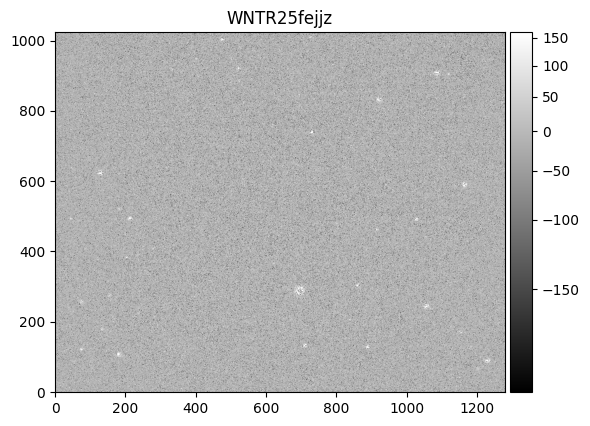

In [4]:
# Try to run the cal pipeline on a dither set
import os
from glob import glob
targetName = "WNTR25fejjz"
science_dir = os.path.join(os.path.expanduser("~"), "data", 
                           "commissioning", "20250803", targetName)

science_image = glob(os.path.join(science_dir, "*.fits"))[0]

bkg_images = glob(os.path.join(science_dir, "*.fits"))[4:]

print("Science image:", science_image)
print("Background images:", bkg_images)

callimg = pirt.calibrate_image(science_image = science_image,
                               background_image_list = bkg_images)
callimg.plot_image(title = targetName)
callimg.save_image(os.path.join(science_dir, f"{targetName}_calibrated.fits"))

Focus images: ['C:\\Users\\oir-user\\data\\commissioning\\20250803\\focus\\scicam_20250804T103631.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\focus\\scicam_20250804T103701.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\focus\\scicam_20250804T103731.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\focus\\scicam_20250804T103801.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\focus\\scicam_20250804T103831.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\focus\\scicam_20250804T103901.fits', 'C:\\Users\\oir-user\\data\\commissioning\\20250803\\focus\\scicam_20250804T103931.fits']
type(focus_images): <class 'list'>
Focus images loaded: {'': [<imagedaemon.utils.image.Image object at 0x0000022412829950>, <imagedaemon.utils.image.Image object at 0x0000022434C17990>, <imagedaemon.utils.image.Image object at 0x0000022434DD95D0>, <imagedaemon.utils.image.Image object at 0x0000022434C713D0>, <imagedaemon.utils.image.Image object at 0x00

C:\Users\oir-user\Desktop\GIT\winter-image-daemon\imagedaemon\processing\calibration.py:43: RuntimeWarning: divide by zero encountered in divide
  return data / flat_data
C:\Users\oir-user\Desktop\GIT\winter-image-daemon\imagedaemon\processing\calibration.py:43: RuntimeWarning: invalid value encountered in divide
  return data / flat_data


[DEBUG][] after dither flat: finite=1296704/1310720, min=-inf, max=inf
[DEBUG][] after hot pixel mask: finite=1296704/1310720, min=-inf, max=2.52e+03
running _calibrate_data with addr=
[DEBUG][] raw: finite=1310720/1310720, min=265, max=1.62e+04
[DEBUG][] after dark: finite=1310720/1310720, min=-3.47e+03, max=5.69e+03
[DEBUG][] after dither flat: finite=1296704/1310720, min=-inf, max=inf
[DEBUG][] after hot pixel mask: finite=1296704/1310720, min=-inf, max=3.97e+03
running _calibrate_data with addr=
[DEBUG][] raw: finite=1310720/1310720, min=265, max=1.62e+04
[DEBUG][] after dark: finite=1310720/1310720, min=-3.5e+03, max=4.16e+03
[DEBUG][] after dither flat: finite=1296704/1310720, min=-inf, max=inf
[DEBUG][] after hot pixel mask: finite=1296704/1310720, min=-inf, max=3.07e+03
running _calibrate_data with addr=
[DEBUG][] raw: finite=1310720/1310720, min=265, max=1.62e+04
[DEBUG][] after dark: finite=1310720/1310720, min=-3.44e+03, max=2.57e+03
[DEBUG][] after dither flat: finite=12967

FileNotFoundError: [WinError 2] The system cannot find the file specified

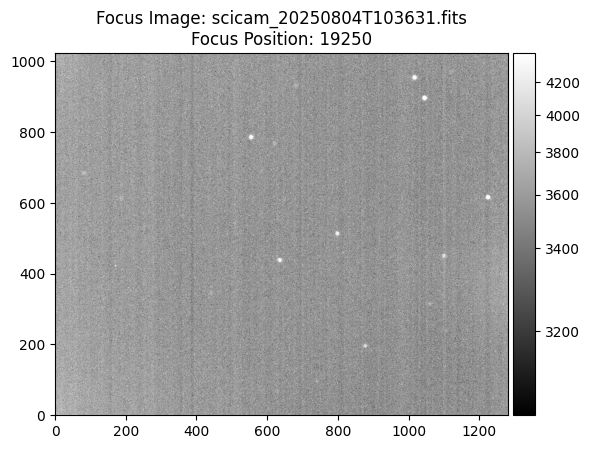

In [5]:
# Focus attempt
from imagedaemon.utils.image import Image
focus_dir = os.path.join(os.path.expanduser("~"), "data",
                        "commissioning", "20250803", "focus")
focus_images = glob(os.path.join(focus_dir, "*.fits"))

# plot one
img = Image(focus_images[0])
img.plot_image(title = f"Focus Image: {img.filename}\nFocus Position: {img.header['FOCPOS']:.0f}",)

print(f"Focus images: {focus_images}")
print(f"type(focus_images): {type(focus_images)}")
res = pirt._load_focus_images(focus_images)
print(f"Focus images loaded: {res}")
# calibrate all the focus images
focus_calibrated = pirt.calibrate_for_focus(
    image_paths = focus_images,
    out_dir = os.path.join(os.path.expanduser("~"), "data", "tmp"),
)

print(f"Focus calibrated images: {focus_calibrated}")

# now try for a focus loop

results = pirt.run_focus_loop(image_list = focus_images,
                                   addrs = None,
                                   output_dir = None)

print(f"Focus loop results: {results}")

# plot the first one
#focus_calibrated[0].plot_image(f"First Focus Calibrated Image: {focus_calibrated[0].filename}",)